# Résolution numérique et analyse du modèle de Vasicek pour le pricing d'obligations zéro-coupon

Ce notebook est composé de deux parties. La première présente l'implémentation et la comparaison de plusieurs méthodes numériques pour résoudre l'équation aux dérivées partielles (EDP) associée au modèle de Vasicek. La seconde étudie la sensibilité à la volatilité du prix d'une obligation sous le modèle de Vasicek, puis simule plusieurs scénarios pour étudier les distributions de prix en fonction de différentes volatilités. 

## Modèle de Vasicek

Dans ce modèle, le **taux d'intérêt instantané** $r(t)$ suit l'équation différentielle stochastique :

```math
\mathrm{d}r(t)=\kappa\bigl(\gamma-r(t)\bigr)\,\mathrm{d}t+\sigma\,\mathrm{d}W(t),
```
où $W(t)$ est un mouvement brownien standard, $\kappa>0$ la vitesse de réversion, $\gamma$ la moyenne de long terme du taux et $\sigma$ la volatilité. 

La valeur $V(r,t)$ d'une obligation zéro-coupon, arrivant à maturité au temps $T$, satisfait l'**EDP** suivante (sous la mesure neutre au risque) :

```math
\frac{\partial V}{\partial t} \;+\; \kappa\,(\gamma-r)\,\frac{\partial V}{\partial r} \;+\; \frac12\,\sigma^2\,\frac{\partial^2 V}{\partial r^2} \;-\; r\,V \;=\; 0,\quad V(r,T)=1.
```

## Transformation $Q(\tau,r)$

Pour faciliter la résolution numérique, on effectue le changement de variable :

```math
\tau=T-t,\quad Q(\tau, r)=V(r, T-\tau),\quad Q(0,r)=1.
```

Ainsi, l'EDP s'exprime en fonction de $\tau$. Une fois $Q(\tau, r)$ obtenue numériquement, on retrouve $V(r,t)$ en inversant le temps :\n

```math
V(r,t)=Q(\tau=T-t, r), \quad\text{en inversant l'ordre temporel du tableau obtenu.}
```

## Méthodes numériques implémentées

1. **Méthode d'Euler explicite**
2. **Méthode d'Euler implicite**, avec l'**algorithme de Thomas**
3. **Méthode de Crank-Nicolson**
4. **Méthode par éléments finis (FEM)**

## Solution analytique

Le modèle de Vasicek admet une **solution analytique** en forme fermée. Plus précisément, on peut montrer que :

```math
V(r,t)=A(t,T)\,e^{-B(t,T)\,r},
```
où

```math
B(t,T)=\frac{1-e^{-\kappa\,(T-t)}}{\kappa},\quad
A(t,T)=\exp\Biggl[\Bigl(\gamma-\frac{\sigma^2}{2\,\kappa^2}\Bigr)\,\bigl(B(t,T)-(T-t)\bigr)-\frac{\sigma^2\,B(t,T)^2}{4\,\kappa}\Biggr].
```

Nous implémenterons cette solution analytique pour évaluer et comparer la précision des méthodes numériques.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

#Définition des paramètres du modèle : Il est possible de les modifier pour tester différents scénarios.
kappa=0.1     
gamma=0.05     
sigma=0.01     
T=1.0         

#Définition du nombres de points pour la discrétisation temporelle et spatiale
nb_steps=100     
nb_points_r=50    
dtau=T / nb_steps 
r_min=0.0
r_max=0.15
dr=(r_max-r_min) / nb_points_r

#Définition des maillages
tau_grid=np.linspace(0, T, nb_steps+1)  
t_grid=(T-tau_grid)[::-1]               
r_grid=np.linspace(r_min, r_max, nb_points_r+1)

In [19]:
#On calcule la solution analytique à l'aide de la solution en forme fermée. 
def compute_B(t):
    return (1-np.exp(-kappa*(T-t))) / kappa

def compute_A(t):
    b_val=compute_B(t)
    return np.exp((gamma-sigma**2 / (2*kappa**2))*(b_val-(T-t))-(sigma**2*b_val**2) / (4*kappa))

def sol_analytique(t, r):
    return compute_A(t)*np.exp(-compute_B(t)*r)

#On évalue la solution analytique à chaque point de la grille afin de pouvoir la tracer sur les maillages définis
analytique_solution=np.zeros((nb_steps+1, nb_points_r+1))
for i, t_val in enumerate(t_grid):
    analytique_solution[i, :]=sol_analytique(t_val, r_grid)

## 1) Méthode d'Euler explicite

La méthode d'Euler explicite approxime la dérivée temporelle $\frac{\partial Q}{\partial \tau}$ par une différence "avant" et les dérivées spatiales par des différences centrées.

Pour chaque point intérieur $i$, le schéma s'écrit :

```math
Q_{i}^{n+1}=Q_{i}^{n}+\Delta\tau\biggl[\kappa(\gamma-r_{i})\frac{Q_{i+1}^n-Q_{i-1}^n}{2\,\mathrm{d}r}+\frac12\sigma^2\frac{Q_{i+1}^n-2Q_{i}^n+Q_{i-1}^n}{(\mathrm{d}r)^2}-r_i Q_{i}^n\biggr].
```

Les **conditions aux bords** $Q_{0}^{n+1}$ et $Q_{M}^{n+1}$ sont imposées via la **solution analytique**. 
Enfin, on repasse à $V$ via $t=T-\tau$. 

In [20]:
def euler_explicit():
    Q=np.ones((nb_steps+1, nb_points_r+1))  #Q(0,r)=1 pour tout r

    for n in range(nb_steps):
        for i in range(1, nb_points_r):
            dQ_dr=(Q[n, i+1]-Q[n, i-1]) / (2*dr)
            d2Q_dr2=(Q[n, i+1]-2*Q[n, i]+Q[n, i-1]) / (dr**2)
            L_operator=(kappa*(gamma-r_grid[i])*dQ_dr
                         +0.5*sigma**2*d2Q_dr2
                         -r_grid[i]*Q[n, i])
            Q[n+1, i]=Q[n, i]+dtau*L_operator

        #Conditions aux bords via la solution analytique
        Q[n+1, 0]=sol_analytique(T-tau_grid[n+1], r_min)
        Q[n+1, nb_points_r]=sol_analytique(T-tau_grid[n+1], r_max)

    #Conversion de Q(tau,r) en V(r,t)
    V_explicit=Q[::-1, :]
    return V_explicit

V_explicit=euler_explicit()

## 2) Méthode d'Euler implicite

Avant de passer aux détails et à l'implémentation de la méthode d'Euler implicite, attardons-nous sur **l'algorithme de Thomas** qui est utilisé dans cette partie pour résoudre efficacement le système tridiagonal obtenu. Ce même algorithme est également utilisé pour l'implémentation de la méthode de Crank-Nicolson.

### L'algorithme de Thomas (pour la résolution de systèmes tridiagonaux)

Avant  **système linéaire tridiagonal**. 

Un systme tridiagonal s'écrit :

```math
a_1 x_1+b_1 x_2          =d_1\\
c_1 x_1+a_2 x_2+b_2 x_3=d_2\\
           c_2 x_2+a_3 x_3+b_3 x_4=d_3\\
\cdots\\
           \quad c_{n-1} x_{n-1}+a_n x_n=d_n.
```

L'**algorithme de Thomas** résout ce système en deux étapes :

1. **Phase de descente** : on élimine les inconnues $ x_1, x_2,\dots $ pour rendre la matrice triangulaire supérieure.

2. **Phase de remontée** : on remonte dans la matrice triangulaire pour trouver la solution $ x_n, x_{n-1},\dots $.

Il est très efficace (complexité linéaire $ O(n) $) et parfaitement adapté à notre implémentation des méthodes d'Euler implicite et de Crank-Nicolson, puisque ces dernières aboutissent à un système tridiagonal.

### Méthode d'Euler implicite

Pour chaque point intérieur $ i=1,\dots,M-1 $, nous approchons les dérivées spatiales par des différences finies :

1. **Dérivée première en $r$**  
   $$
   \frac{\partial Q}{\partial r}\Bigl|_{(\tau_n,r_i)}
  =\frac{Q^n_{i+1}-Q^n_{i-1}}{\,2\,\Delta r\,}
   $$

2. **Dérivée seconde en $r$**  
   $$
   \frac{\partial^2 Q}{\partial r^2}\Bigl|_{(\tau_n,r_i)}
  =\frac{Q^n_{i+1}-2\,Q^n_i+Q^n_{i-1}}{(\Delta r)^2}
   $$

La méthode d’Euler implicite consiste à évaluer la dérivée temporelle au niveau $n+1$. On écrit alors, pour tout $i$ :
$$
\frac{Q^{n+1}_i-Q^n_i}{\Delta \tau}
= \kappa(\gamma-r_i)\,\frac{Q^{n+1}_{i+1}-Q^{n+1}_{i-1}}{2\,\Delta r}
\;+\;\tfrac12\,\sigma^2\,\frac{Q^{n+1}_{i+1}-2\,Q^{n+1}_i+Q^{n+1}_{i-1}}{(\Delta r)^2}
\;-\;r_i\,Q^{n+1}_i
$$

En regroupant tous les termes pour $i=1,\dots,M-1$, on obtient un système de la forme :
$$
Q^{n+1}_i
\;-\;\Delta\tau\,\Bigl[\,
\kappa(\gamma-r_i)\,\frac{Q^{n+1}_{i+1}-Q^{n+1}_{i-1}}{2\,\Delta r}
\;+\;\tfrac12\,\sigma^2\,\frac{Q^{n+1}_{i+1}-2\,Q^{n+1}_i+Q^{n+1}_{i-1}}{(\Delta r)^2}
\;-\;r_i\,Q^{n+1}_i
\Bigr]
= Q^n_i
$$

On impose ensuite les conditions aux bords (valeurs de $Q^{n+1}_0$ et $Q^{n+1}_M$) dans les équations de bord et on résout ce système tridiagonal via l'algorithme de Thomas à chaque pas de temps $n$. Enfin, lorsque $n$ parcourt $0,\dots,N$, on reconstitue la solution $Q^n_i$. Enfin, on repasse à $V$ via $t=T-\tau$. 


In [21]:
def thomas_algorithm(a_vec, b_vec, c_vec, d_vec):

    n=len(b_vec)
    cp=np.zeros(n-1)
    dp=np.zeros(n)

    # Phase de descente
    cp[0]=c_vec[0] / b_vec[0]
    dp[0]=d_vec[0] / b_vec[0]
    for i in range(1, n-1):
        denom=b_vec[i]-a_vec[i]*cp[i-1]
        cp[i]=c_vec[i] / denom
        dp[i]=(d_vec[i]-a_vec[i]*dp[i-1]) / denom

    dp[n-1]=(d_vec[n-1]-a_vec[n-1]*dp[n-2]) / (
        b_vec[n-1]-a_vec[n-1]*cp[n-2]
    )

    # Phase de remontée
    x=np.zeros(n)
    x[-1]=dp[-1]
    for i in range(n-2, -1, -1):
        x[i]=dp[i]-cp[i]*x[i+1]

    return x


def euler_implicit():

    Q=np.ones((nb_steps+1, nb_points_r+1))  # Q(0, r)=1

    for n in range(nb_steps):
        # Vecteurs pour le système tridiagonal
        a_vec=np.zeros(nb_points_r-1)
        b_vec=np.zeros(nb_points_r-1)
        c_vec=np.zeros(nb_points_r-1)
        d_vec=np.zeros(nb_points_r-1)


        for i in range(1, nb_points_r):
            idx=i-1
            #Définition des coefficients
            alpha=dtau*(0.5*sigma**2 / (dr**2)-kappa*(gamma-r_grid[i]) / (2*dr))
            beta =1+dtau*(r_grid[i]+sigma**2 / (dr**2))
            gamma_coef=dtau*(0.5*sigma**2 / (dr**2)+kappa*(gamma-r_grid[i]) / (2*dr))

            a_vec[idx]=0.0 if (idx==0) else -alpha
            b_vec[idx]=beta
            c_vec[idx]=-gamma_coef if idx < (nb_points_r-2) else 0.0

            # Second membre
            d_vec[idx]=Q[n, i]

        #Conditions aux bords 
        Q[n+1, 0]          =sol_analytique(T-tau_grid[n+1], r_min)
        Q[n+1, nb_points_r]=sol_analytique(T-tau_grid[n+1], r_max)

        d_vec[0] += dtau*(0.5*sigma**2 / (dr**2)-kappa*(gamma-r_grid[1]) / (2*dr))*Q[n+1, 0]
        d_vec[-1] += dtau*(0.5*sigma**2 / (dr**2)+kappa*(gamma-r_grid[nb_points_r-1]) / (2*dr))*Q[n+1, nb_points_r]

        #Résolution du système tridiagonal via l'algorithme de Thomas
        Q_interior=thomas_algorithm(a_vec, b_vec, c_vec, d_vec)

        Q[n+1, 1:nb_points_r]=Q_interior

    #Passage de Q à V
    V_implicit=Q[::-1, :]
    return V_implicit


V_implicit=euler_implicit()

### Méthode de Crank–Nicolson (différences finies)

Pour chaque point intérieur $i=1,\dots,M-1$, nous approchons les dérivées spatiales par des différences finies :

1. **Dérivée première en $r$**  
   $$
   \frac{\partial Q}{\partial r}\Bigl|_{(\tau_n,r_i)}
  =\frac{\,Q^n_{i+1}-Q^n_{i-1}\,}{\,2\,\Delta r\,}
   $$

2. **Dérivée seconde en $r$**  
   $$
   \frac{\partial^2 Q}{\partial r^2}\Bigl|_{(\tau_n,r_i)}
  =\frac{\,Q^n_{i+1} \;-\;2\,Q^n_i\;+\;Q^n_{i-1}\,}{(\Delta r)^2}
   $$

On substitue ensuite ces expressions dans le schéma de Crank–Nicolson en temps, qui repose sur la formule :
$$
\frac{\,Q^{n+1}_i \;-\; Q^n_i\,}{\Delta\tau}
= \frac12\,\Bigl(\mathcal{L}Q^{n+1}_i \;+\;\mathcal{L}Q^n_i\Bigr)
$$
où $\mathcal{L}$ représente la partie discrète de l’opérateur
$\;\kappa(\gamma-r)\tfrac{\partial}{\partial r} \;+\; \tfrac12\,\sigma^2\,\tfrac{\partial^2}{\partial r^2} \;-\;r.$

Concrètement, en explicitant $\mathcal{L}Q^{n+1}_i$ et $\mathcal{L}Q^n_i$ à l’aide des dérivées ci-dessus (et en imposant les conditions aux bords de la solution analytique), nous obtenons, pour chaque $i$ :
$$
\frac{Q^{n+1}_i-Q^n_i}{\Delta\tau}
= \frac12\Bigl[\,
\kappa(\gamma-r_i)\,\frac{Q^{n+1}_{i+1}-Q^{n+1}_{i-1}}{\,2\,\Delta r\,}
\;+\;\tfrac12\,\sigma^2\,\frac{Q^{n+1}_{i+1}-2\,Q^{n+1}_i+Q^{n+1}_{i-1}}{(\Delta r)^2}
\;-\;r_i\,Q^{n+1}_i
\;+\;\kappa(\gamma-r_i)\,\frac{Q^n_{i+1}-Q^n_{i-1}}{\,2\,\Delta r\,}
\;+\;\tfrac12\,\sigma^2\,\frac{Q^n_{i+1}-2\,Q^n_i+Q^n_{i-1}}{(\Delta r)^2}
\;-\;r_i\,Q^n_i
\Bigr]
$$

En réarrangeant ces termes pour tous les $i$, on obtient le système tridiagonal suivant :
$$
\bigl(I-\tfrac{\Delta\tau}{2}\,\mathcal{L}\bigr)\,Q^{n+1}
= \bigl(I+\tfrac{\Delta\tau}{2}\,\mathcal{L}\bigr)\,Q^n
$$
que l’on résout à chaque pas de temps $n$. On reconstruit alors la suite $Q^n_i$, puis la solution $V(r,t)$ en inversant $\tau=T-t$. 


In [22]:
def crank_nicolson():
    r_interior=r_grid[1:nb_points_r]
    coef_a=kappa*(gamma-r_interior) / (2*dr)
    coef_d=sigma**2 / (2*dr**2)

    #Définition de tous les coefficients du système
    lower_coeff=-(dtau/2)*(-coef_a+coef_d)
    diag_coeff =1-(dtau/2)*(-2*coef_d-r_interior)
    upper_coeff=-(dtau/2)*(coef_a+coef_d)
    lower_coeff_rhs= (dtau/2)*(-coef_a+coef_d)
    diag_coeff_rhs =1+(dtau/2)*(-2*coef_d-r_interior)
    upper_coeff_rhs= (dtau/2)*(coef_a+coef_d)

    # Assemblage de la matrice A (implicit)
    A_matrix=np.zeros((nb_points_r-1, nb_points_r-1))
    A_matrix[0, 0]=diag_coeff[0]
    if nb_points_r-1 > 1:
        A_matrix[0, 1]=upper_coeff[0]
    for i in range(1, nb_points_r-1):
        A_matrix[i, i-1]=lower_coeff[i]
        A_matrix[i, i]  =diag_coeff[i]
        if i < nb_points_r-2:
            A_matrix[i, i+1]=upper_coeff[i]
    if nb_points_r-1 > 1:
        A_matrix[-1, -2]=lower_coeff[-1]
    A_matrix[-1, -1]=diag_coeff[-1]

    Q=np.ones((nb_steps+1, nb_points_r+1))
    for n in range(nb_steps):
        #Définition des conditions aux bords
        Q[n+1, 0]=sol_analytique(T-tau_grid[n+1], r_min)
        Q[n+1, nb_points_r]=sol_analytique(T-tau_grid[n+1], r_max)

        #Second membre
        d=np.zeros(nb_points_r-1)
        for i in range(1, nb_points_r):
            idx=i-1
            d[idx]=diag_coeff_rhs[idx]*Q[n, i]
            if i-1>=0:
                d[idx]+=lower_coeff_rhs[idx]*Q[n, i-1]
            if i+1<=nb_points_r:
                d[idx]+=upper_coeff_rhs[idx]*Q[n, i+1]

        #Conditions aux bords pour les seconds membres
        d[0]+=(dtau/2)*(-coef_a[0]+coef_d)* Q[n+1, 0]
        d[-1]+=(dtau/2)*( coef_a[-1]+coef_d)*Q[n+1, nb_points_r]


        a_vec=np.zeros(nb_points_r-1)
        b_vec=np.zeros(nb_points_r-1)
        c_vec=np.zeros(nb_points_r-1)

        for i in range(nb_points_r-1):
            if i > 0:
                a_vec[i]=A_matrix[i, i-1]
            b_vec[i]=A_matrix[i, i]
            if i < nb_points_r-2:
                c_vec[i]=A_matrix[i, i+1]

        Q_inner=thomas_algorithm(a_vec, b_vec, c_vec, d)
        Q[n+1, 1:nb_points_r]=Q_inner

    V_crank=Q[::-1, :]
    return V_crank

V_crank=crank_nicolson()

## 4) Méthode des éléments finis (FEM)

**Formulation faible**  
Nous partons de l’équation :
$$
-\frac{\partial Q}{\partial \tau}
\;+\;\kappa(\gamma-r)\,\frac{\partial Q}{\partial r}
\;+\;\tfrac12\,\sigma^2\,\frac{\partial^2 Q}{\partial r^2}
\;-\;r\,Q
\;=\;0
$$
On la multiplie par une fonction test $\omega$ et on intègre par parties. Pour $\omega \in H^1_0$, cela conduit à la formulation faible :
$$
-\frac{d}{d\tau}\,\int Q\,\omega\,dr
\;+\;\int \Bigl[\,
\kappa(\gamma-r)\,\frac{\partial Q}{\partial r}\,\omega
\;-\;\tfrac12\,\sigma^2\,\frac{\partial Q}{\partial r}\,\frac{\partial \omega}{\partial r}
\;-\;r\,Q\,\omega
\Bigr]\,dr
\;=\;0
$$

**Fonctions de base et projection de $Q$.**  
On considère une discrétisation par éléments finis de type $\mathbb{P}_1$.  
On définit des fonctions de base $\{\varphi_j\}_{j=1,\dots,M-1}$, chacune étant affine par morceaux, et on approche la solution $Q(\tau,r)$ par :
$$
Q_h(\tau, r)
\;=\;\sum_{j=1}^{M-1} Q_j(\tau)\,\varphi_j(r)
$$

**Équation différentielle ordinaire (matricielle).**  
En notant $\mathbf{Q}(\tau)=\bigl(Q_1(\tau), \dots, Q_{M-1}(\tau)\bigr)^{\mathsf{T}}$
la formulation variationnelle aboutit à l’EDO :
$$
-\;M\,\frac{d\mathbf{Q}}{d\tau}
\;+\;B\,\mathbf{Q}
\;=\;0
$$
où $M$ et $B$ sont les matrices de masse et de rigidité, définies par :
$$
M_{ij} \;=\;\int
\varphi_i(r)\,\varphi_j(r)\,dr
\quad
B_{ij}\;=\;\int \Bigl[
\,\kappa(\gamma-r)\,\frac{\partial\varphi_j}{\partial r}\,\varphi_i
\;-\;\tfrac12\,\sigma^2\,\frac{\partial\varphi_j}{\partial r}\,\frac{\partial\varphi_i}{\partial r}
\;-\;r\,\varphi_j\,\varphi_i
\Bigr]\,dr
$$

**Application du schéma de Crank–Nicolson**  
Pour résoudre cette EDO, on utilise un schéma de Crank–Nicolson en temps :
$$
M\,\frac{\mathbf{Q}^{n+1}-\mathbf{Q}^{n}}{\Delta\tau}
\;=\;\,B\,\frac{\bigl(\mathbf{Q}^{n+1}+\mathbf{Q}^{n}\bigr)}{2}
$$
En réarrangeant, à chaque pas de temps $\Delta\tau$, on obtient :
$$
\bigl(M \;-\;\tfrac{\Delta\tau}{2}\,B\bigr)\,\mathbf{Q}^{n+1}
\;=\;\bigl(M \;+\;\tfrac{\Delta\tau}{2}\,B\bigr)\,\mathbf{Q}^{n}
$$
On construit ainsi la suite $\{\mathbf{Q}^n\}$, ce qui donne à chaque instant $\tau_n$ la solution approchée $Q_h(\tau_n,r)$. Enfin, on repasse à $V$ via $t=T-\tau$. 


In [23]:
def fem_method():
    r_nodes=r_grid.copy()
    M_nodes=nb_points_r  
    M_global=np.zeros((M_nodes+1, M_nodes+1))
    B_global=np.zeros((M_nodes+1, M_nodes+1))


#On commence par définir les fonctions phi qui forment une base de l'espace des éléments finis, ainsi que leur dérivée
    def phi(i, r_val):
        if i==0:
            return (r_nodes[1]-r_val)/dr if (r_nodes[0]<=r_val<=r_nodes[1]) else 0.0
        elif i==M_nodes:
            return (r_val-r_nodes[M_nodes-1])/dr if (r_nodes[M_nodes-1]<=r_val<=r_nodes[M_nodes]) else 0.0
        else:
            if (r_val < r_nodes[i-1]) or (r_val > r_nodes[i+1]):
                return 0.0
            if r_val<=r_nodes[i]:
                return (r_val-r_nodes[i-1])/dr
            else:
                return (r_nodes[i+1]-r_val)/dr

    def dphi(i, r_val):
        if i==0:
            return -1.0/dr if (r_nodes[0]<=r_val<=r_nodes[1]) else 0.0
        elif i==M_nodes:
            return 1.0/dr if (r_nodes[M_nodes-1]<=r_val<=r_nodes[M_nodes]) else 0.0
        else:
            if (r_val < r_nodes[i-1]) or (r_val > r_nodes[i+1]):
                return 0.0
            if r_val < r_nodes[i]:
                return 1.0/dr
            else:
                return -1.0/dr

#On définit les matrices de l'EDO matricielle obtenue, coefficient par coefficient grâce à la fonction integrate.quad de scipy
    for i in range(M_nodes+1):
        if i==0:
            support_i=(r_nodes[0], r_nodes[1])
        elif i==M_nodes:
            support_i=(r_nodes[M_nodes-1], r_nodes[M_nodes])
        else:
            support_i=(r_nodes[i-1], r_nodes[i+1])
        for j in range(M_nodes+1):
            if j==0:
                support_j=(r_nodes[0], r_nodes[1])
            elif j==M_nodes:
                support_j=(r_nodes[M_nodes-1], r_nodes[M_nodes])
            else:
                support_j=(r_nodes[j-1], r_nodes[j+1])
            a_int=max(support_i[0], support_j[0])
            b_int=min(support_i[1], support_j[1])
            if a_int < b_int:
                M_global[i, j]=quad(lambda x: phi(i, x)*phi(j, x), a_int, b_int, limit=100)[0]
                B_global[i, j]=quad(lambda x: (kappa*(gamma-x)*dphi(j, x)*phi(i, x)-0.5*sigma**2*dphi(j, x)*dphi(i, x)-x*phi(j, x)*phi(i, x)),a_int, b_int, limit=100)[0]

    LHS=M_global-(dtau/2)*B_global 
    RHS=M_global+(dtau/2)*B_global  


    Q=np.ones(M_nodes+1) #Q(0,r)=1 pour tout r
    Q_all=[Q.copy()]

    for n in range(nb_steps):
        #Conditions aux bords 
        Q_left=sol_analytique(T-tau_grid[n+1], r_min)
        Q_right=sol_analytique(T-tau_grid[n+1], r_max)

        #Second membre
        b_sys=RHS @ Q
        A_sys=LHS.copy()

        
        for i in range(1, M_nodes):
            b_sys[i] -= A_sys[i, 0]*Q_left+A_sys[i, M_nodes]*Q_right
            A_sys[i, 0]=0.0
            A_sys[i, M_nodes]=0.0
        A_sys[0, :]=0.0
        A_sys[0, 0]=1.0
        b_sys[0]=Q_left
        A_sys[M_nodes, :]=0.0
        A_sys[M_nodes, M_nodes]=1.0
        b_sys[M_nodes]=Q_right


        Q_new=np.linalg.solve(A_sys, b_sys)
        Q=Q_new.copy()
        Q_all.append(Q.copy())

    Q_all=np.array(Q_all)
    # Conversion de Q(0,r) en V(r,t)
    V_fem=Q_all[::-1, :]
    return V_fem

V_fem=fem_method()

## 5) Comparaison des méthodes

Nous comparons ci-dessous :

- **Solution analytique** $ V(r,t) $
- **Euler explicite** $ V_{\mathrm{expl}}(r,t) $
- **Euler implicite** $ V_{\mathrm{impl}}(r,t) $
- **Crank-Nicolson** $ V_{\mathrm{CN}}(r,t) $
- **Éléments finis (FEM)** $ V_{\mathrm{FEM}}(r,t) $

On affiche successivement les surfaces et nous calculons l'erreur absolue.

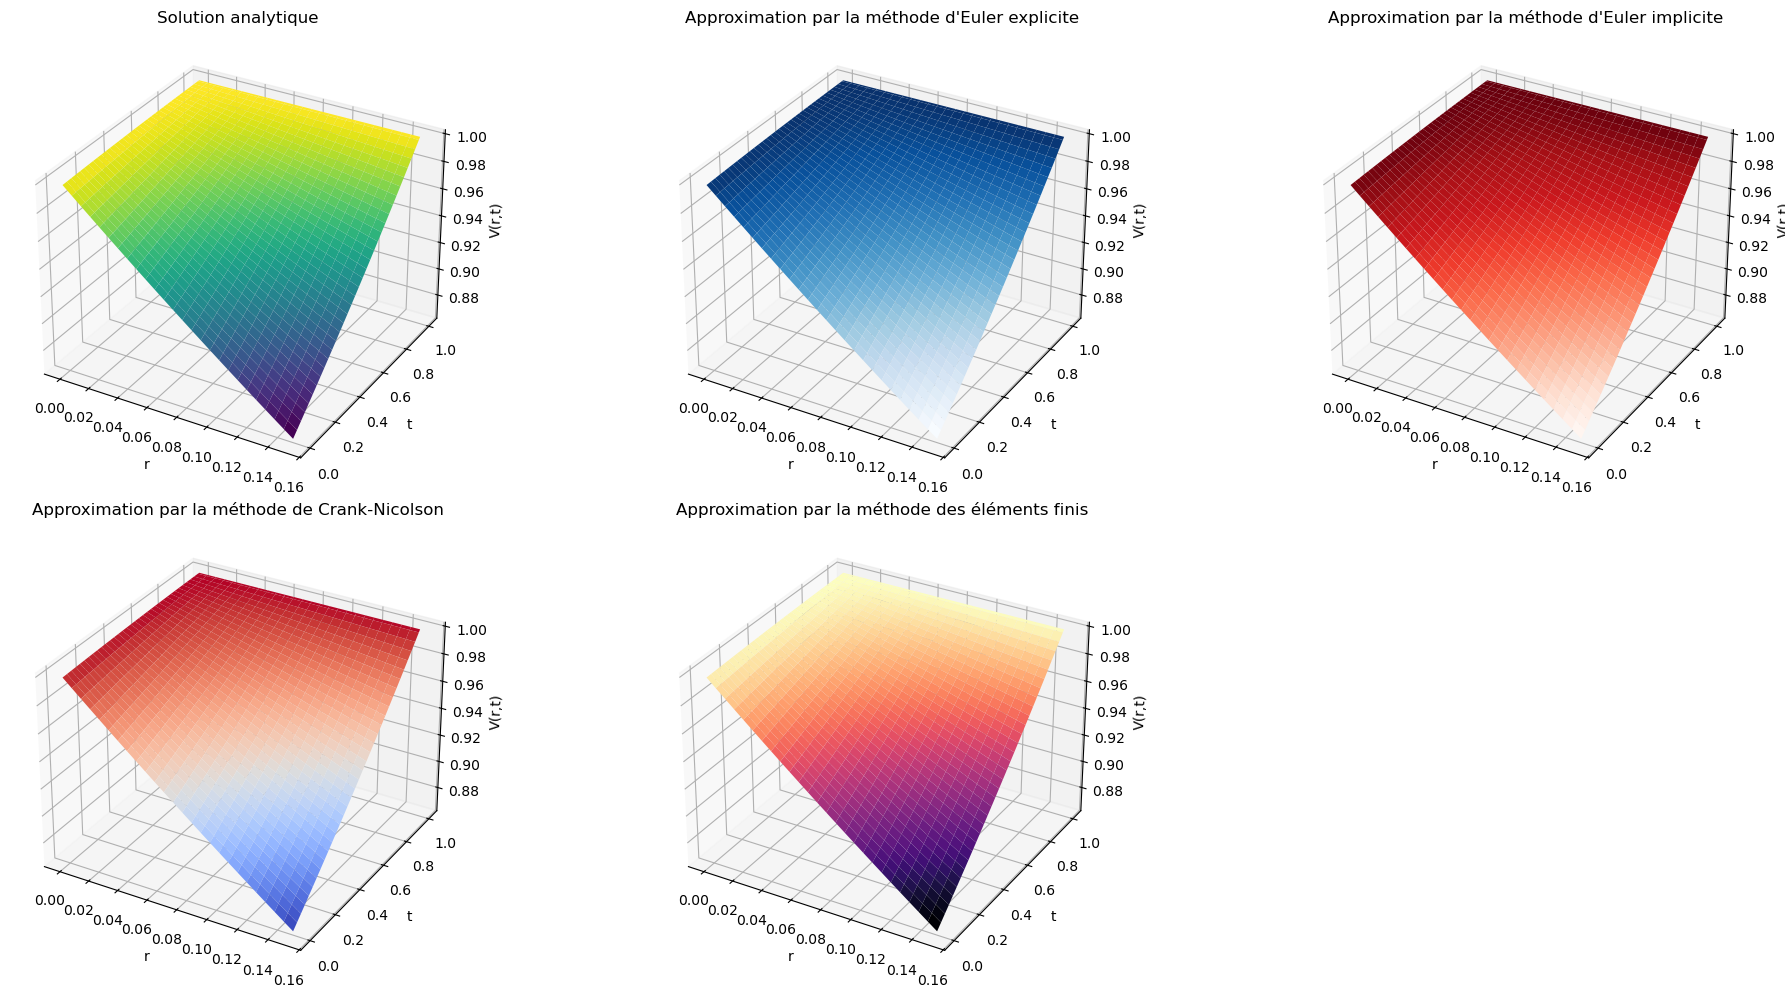

In [24]:
#Définition des grilles et mises en forme des tracés 3D

R_mesh, T_mesh=np.meshgrid(r_grid, t_grid)

fig=plt.figure(figsize=(20, 10))

ax1=fig.add_subplot(231, projection='3d')
ax1.plot_surface(R_mesh, T_mesh, analytique_solution, cmap='viridis', edgecolor='none')
ax1.set_title('Solution analytique')
ax1.set_xlabel('r')
ax1.set_ylabel('t')
ax1.set_zlabel('V(r,t)')

ax2=fig.add_subplot(232, projection='3d')
ax2.plot_surface(R_mesh, T_mesh, V_explicit, cmap='Blues', edgecolor='none')
ax2.set_title("Approximation par la méthode d'Euler explicite")
ax2.set_xlabel('r')
ax2.set_ylabel('t')
ax2.set_zlabel('V(r,t)')

ax3=fig.add_subplot(233, projection='3d')
ax3.plot_surface(R_mesh, T_mesh, V_implicit, cmap='Reds', edgecolor='none')
ax3.set_title("Approximation par la méthode d'Euler implicite")
ax3.set_xlabel('r')
ax3.set_ylabel('t')
ax3.set_zlabel('V(r,t)')

ax4=fig.add_subplot(234, projection='3d')
ax4.plot_surface(R_mesh, T_mesh, V_crank, cmap='coolwarm', edgecolor='none')
ax4.set_title("Approximation par la méthode de Crank-Nicolson")
ax4.set_xlabel('r')
ax4.set_ylabel('t')
ax4.set_zlabel('V(r,t)')

ax5=fig.add_subplot(235, projection='3d')
ax5.plot_surface(R_mesh, T_mesh, V_fem, cmap='magma', edgecolor='none')
ax5.set_title("Approximation par la méthode des éléments finis")
ax5.set_xlabel('r')
ax5.set_ylabel('t')
ax5.set_zlabel('V(r,t)')

plt.tight_layout()
plt.show()

### Calcul et tracé de l'erreur absolue

Pour quantifier la précision de chaque méthode, on définit l'erreur absolue :

```math
E_{\mathrm{method}}(r,t)=\bigl|V_{\mathrm{method}}(r,t)-V(r,t)\bigr|,
```
où $V(r,t)$ désigne la solution analytique.


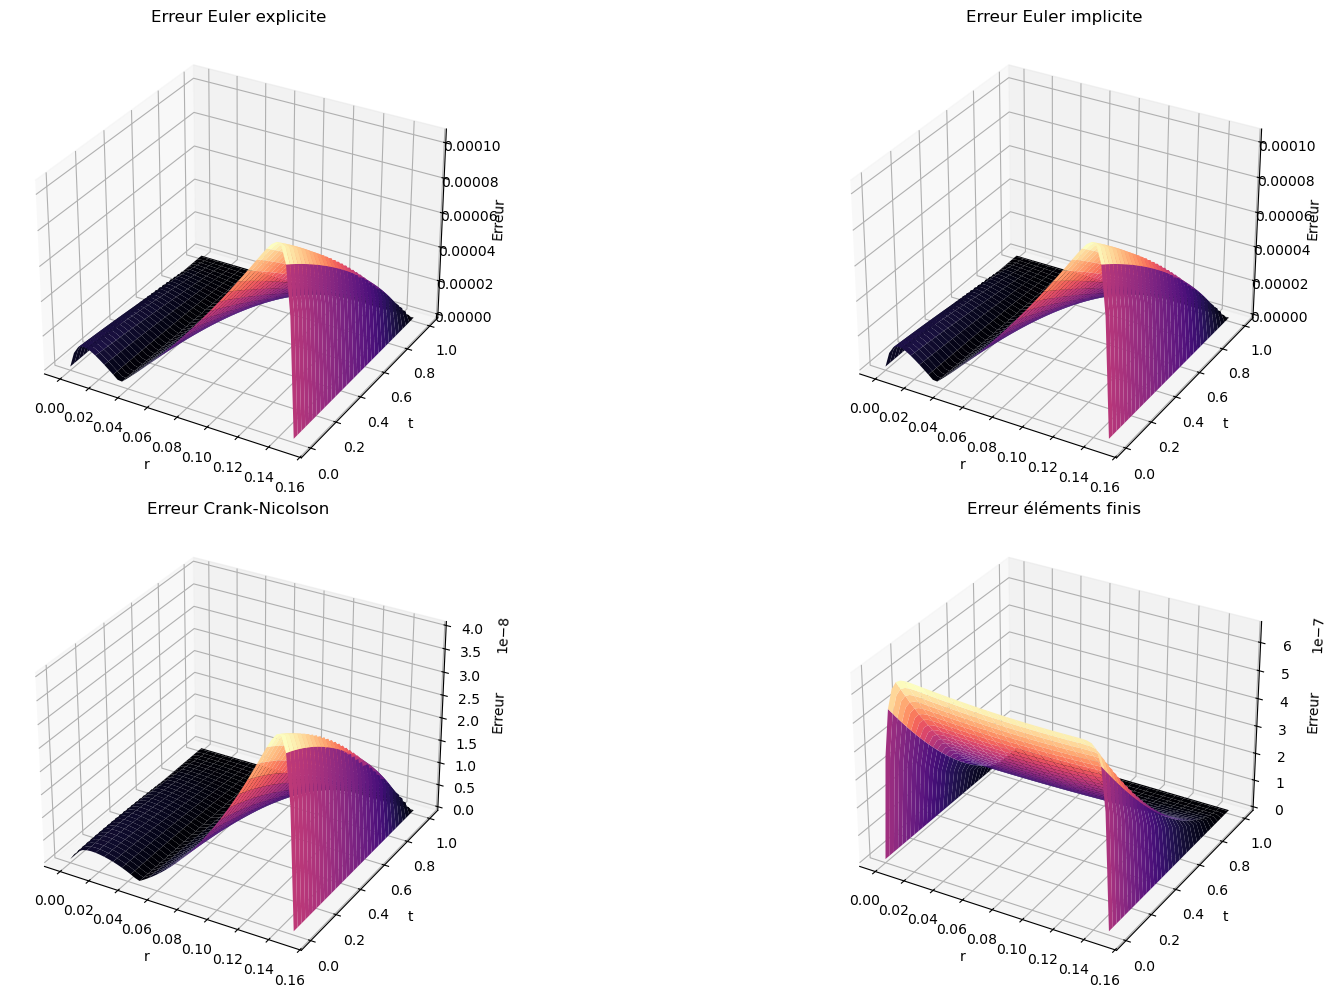

In [25]:
def compute_error(numerical, analytique):
    return np.abs(numerical-analytique)

error_explicit=compute_error(V_explicit, analytique_solution)
error_implicit=compute_error(V_implicit, analytique_solution)
error_crank=compute_error(V_crank, analytique_solution)
error_fem=compute_error(V_fem, analytique_solution)

fig_err=plt.figure(figsize=(20, 10))

ax1_err=fig_err.add_subplot(221, projection='3d')
ax1_err.plot_surface(R_mesh, T_mesh, error_explicit, cmap='magma', edgecolor='none')
ax1_err.set_title("Erreur Euler explicite")
ax1_err.set_xlabel("r")
ax1_err.set_ylabel("t")
ax1_err.set_zlabel("Erreur")

ax2_err=fig_err.add_subplot(222, projection='3d')
ax2_err.plot_surface(R_mesh, T_mesh, error_implicit, cmap='magma', edgecolor='none')
ax2_err.set_title("Erreur Euler implicite")
ax2_err.set_xlabel("r")
ax2_err.set_ylabel("t")
ax2_err.set_zlabel("Erreur")

ax3_err=fig_err.add_subplot(223, projection='3d')
ax3_err.plot_surface(R_mesh, T_mesh, error_crank, cmap='magma', edgecolor='none')
ax3_err.set_title("Erreur Crank-Nicolson")
ax3_err.set_xlabel("r")
ax3_err.set_ylabel("t")
ax3_err.set_zlabel("Erreur")

ax4_err=fig_err.add_subplot(224, projection='3d')
ax4_err.plot_surface(R_mesh, T_mesh, error_fem, cmap='magma', edgecolor='none')
ax4_err.set_title("Erreur éléments finis")
ax4_err.set_xlabel("r")
ax4_err.set_ylabel("t")
ax4_err.set_zlabel("Erreur")

plt.tight_layout()
plt.show()

# Test de Sensibilité à la Volatilité dans le Modèle de Vasicek

Dans cette section, nous étudions l'impact de la volatilité $\sigma$ sur le prix d'une obligation zéro-coupon dans le cadre du modèle de Vasicek. Pour ce faire, nous combinons une simulation du taux d'intérêt à l'aide d'une discrétisation de l'EDS via le schéma d'Euler-Maruyama et le pricing analytique d'une obligation zéro-coupon.

## Simulation du taux d'intérêt

Nous simulons $n$ trajectoires du taux court $r_t$ suivant l'équation différentielle stochastique :
```math
dr_t=\kappa (\gamma - r_t) dt + \sigma dW_t
```

où :
- $\kappa$ est la vitesse de réversion
- $\gamma$ la moyenne de long terme
- $\sigma$ la volatilité
- $dW_t$ représente l'incrément d'un mouvement brownien standard

La méthode d'Euler-Maruyama est utilisée pour discrétiser cette équation sur l'intervalle $[0, T]$. Chaque trajectoire est ainsi obtenue en itérant :

```math
r_{t+\Delta t}=r_t + \kappa (\gamma - r_t) \Delta t + \sigma \varepsilon \sqrt{\Delta t} 
``` 

avec $\varepsilon \sim \mathcal{N}(0,1)$

## Pricing de l'obligation zéro-Coupon

Le prix d'une obligation zéro-coupon dans le modèle de Vasicek admet une solution analytique définie précédemment. Pour chaque trajectoire simulée, nous utilisons la valeur simulée du taux d'intérêt pour une volatilité donnée, afin d'appliquer la solution analytique du modèle.

## Sensibilité à la volatilité

L'objectif de cette partie est d'analyser l'impact de la volatilité $\sigma$ sur le prix de l'obligation. Pour cela, nous testons plusieurs valeurs de $\sigma$ :

```math
\sigma \in \{0.005,\; 0.010,\; 0.015,\; 0.020\}
```

Pour chaque valeur de $\sigma$, nous procédons de la manière suivante :
- Génération de trajectoires du taux court $r_t$ sur l'intervalle $[0, T]$
- Utilisation de la solution analytique de l'EDP du modèle de Vasicek pour calculer le prix de l'obligation à $t=0$
- Construction d'histogrammes représentant la distribution des prix obtenus, avec une échelle commune afin de faciliter la comparaison entre les distributions pour différentes volatilités

Cette approche nous permet de visualiser la sensibilité de la volatilité sur la valeur d'une obligation zéro-coupon, en mettant en évidence la manière dont des variations de $\sigma$ modifient la dispersion des prix obtenus.




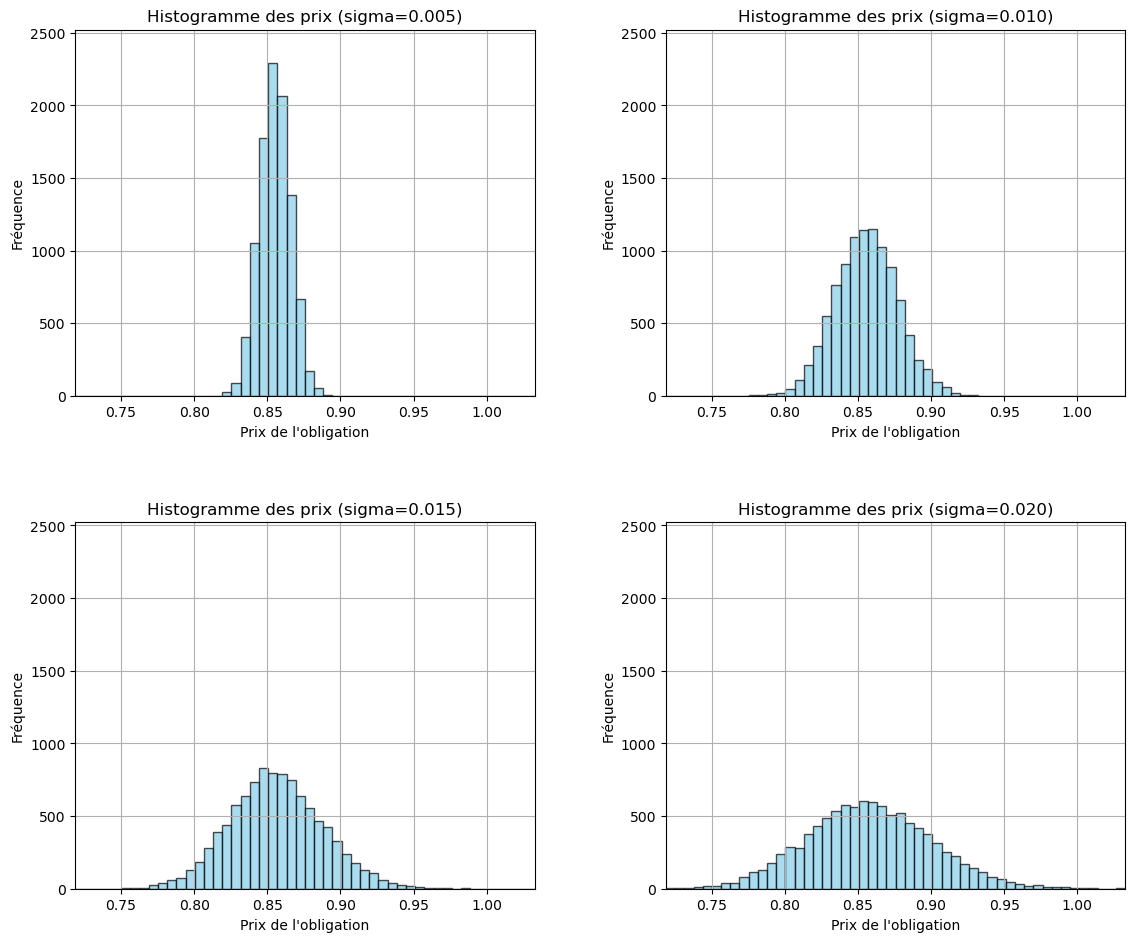

In [26]:
#Simulation des trajectoires du taux d'intérêt selon l'EDS de Vasicek
def simuler_vasicek(r0, kappa, gamma, sigma, T_sim, dt, n_paths):
    
   #Simule n_paths trajectoires du taux r suivant l'EDS de Vasicek sur l'intervalle [0, T_sim] avec un pas dt.Renvoie la grille de temps et la matrice des trajectoires.
   
    n_steps=int(T_sim / dt)
    t_grid=np.linspace(0, T_sim, n_steps + 1)
    trajectoires=np.zeros((n_paths, n_steps + 1))
    trajectoires[:, 0]=r0  # même taux initial pour toutes les trajectoires

    for j in range(1, n_steps + 1):
        dW=np.random.normal(0, np.sqrt(dt), size=n_paths)
        trajectoires[:, j]=trajectoires[:, j - 1] + kappa * (gamma - trajectoires[:, j - 1]) * dt + sigma * dW

    return t_grid, trajectoires


#Pour des raisons de paramètres et de clarté on redéfinit la solution analytique qui prend en compte tous les paramètres du modèle (puisqu'on ne les fixe plus comme auparavant)
def compute_B_bond(kappa, T, t):
    return (1 - np.exp(-kappa * (T - t))) / kappa

def compute_A_bond(kappa, gamma, sigma, T, t):
    B=compute_B_bond(kappa, T, t)
    return np.exp((gamma - sigma**2 / (2 * kappa**2)) * (B - (T - t)) - (sigma**2 * B**2) / (4 * kappa))

def prix_obligation(r, t, T, kappa, gamma, sigma):
    A=compute_A_bond(kappa, gamma, sigma, T, t)
    B=compute_B_bond(kappa, T, t)
    return A * np.exp(-B * r)


#On définit ensuite les paramètres utilisés ici
kappa_sim=0.1
gamma_sim=0.06
r0=0.05          
T_bond=3.0       
t0=0.0          
T_sim=1.0        
dt_sim=0.01
n_sim_paths=10000

#Liste des valeurs de volatilité à tester
sigma_vals=[0.005, 0.01, 0.015, 0.02]

#Dictionnaire pour stocker les prix obtenus pour chaque valeur de la volatilité
prix_dict={}

#Calcul des distributions de prix via simulation
for sigma_val in sigma_vals:
    _, paths_r=simuler_vasicek(r0, kappa_sim, gamma_sim, sigma_val, T_sim, dt_sim, n_sim_paths)
    r_final=paths_r[:, -1]
    prix=prix_obligation(r_final, t0, T_bond, kappa_sim, gamma_sim, sigma_val)
    prix_dict[sigma_val]=prix


#On définit une échelle commune pour tous les histogrammes afin qu'ils soient plus facilement comparables
tous_prix=np.concatenate(list(prix_dict.values()))
x_min, x_max=np.min(tous_prix), np.max(tous_prix)
nb_bins=50
max_count=0
for sigma_val in sigma_vals:
    hist_counts, _=np.histogram(prix_dict[sigma_val], bins=nb_bins, range=(x_min, x_max))
    max_count=max(max_count, np.max(hist_counts))


#On trace un histogramme pour chaque valeur de la volatilité sigma
fig, axes=plt.subplots(2, 2, figsize=(12, 10))
axes=axes.flatten()

for idx, sigma_val in enumerate(sigma_vals):
    ax=axes[idx]
    ax.hist(prix_dict[sigma_val], bins=nb_bins, range=(x_min, x_max),
            alpha=0.7, edgecolor='black', color='skyblue')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, max_count * 1.1)
    ax.set_xlabel("Prix de l'obligation")
    ax.set_ylabel("Fréquence")
    ax.set_title(f"Histogramme des prix (sigma={sigma_val:.3f})")
    ax.grid(True)

plt.subplots_adjust(left=0.072, bottom=0.086, right=0.947, top=0.945,
                    wspace=0.286, hspace=0.345)
plt.show()


## Conclusion

Plusieurs schémas numériques, plus ou moins complexes, ont été implémentés et dont les approximations ont été comparées à la solution analytique du modèle de Vasicek. Nous pouvons dès lors tirer des conclusions sur l'efficacité des méthodes utilisées dans ce contexte.

Comparées à la **solution analytique** :

- Les **schémas d'Euler** (explicite/implicite) sont simples à implémenter (particulièrement le schéma d'Euler explicite) dans ce contexte, et donnent de bons résultats pour un pas de temps suffisamment petit.
- Le **schéma de Crank-Nicolson** apporte souvent une meilleure précision, comme le confirment les mesures d'erreur.
- La **méthode des éléments finis** se montre plus efficace que les méthodes d'Euler, et est théoriquement plus générale, malgré une approche théorique plus compliquée.

En pratique, le choix dépendra des exigences de précision, du temps de calcul et de la facilité d'implémentation. 

Enfin, nous avons étudié la sensibilité du prix d'une obligation à la volatilité via une simulation de l'EDS du modèle pour différentes volatilités, puis en utilisant la solution de l'EDP pour obtenir le prix en fonction de chaque taux simulés. Le résultat de cette partie était prévisible et correspond parfaitement à l'intuition financière que l'on peut avoir quant à une augmentation de la volatilité. 

Dans ce notebook, nous avons montré que toutes ces méthodes permettent d'estimer la valeur de l'obligation zéro-coupon modélisée par Vasicek avec une fidélité notable, relativement à la solution analytique. Les extensions possibles incluent la prise en compte de conditions plus complexes, ou l'étude de modèles voisins (notamment CIR, Hull-White) et l'utilisation de schémas d'ordre supérieur. 